# Diamox

Use this notebook for single animals, otherwise run it in batch from **GLUT1_Analysis**

In [138]:
import os
import subprocess
import numpy as np
import pandas as pd
import MRIhelperfunctions as h
import MRIhelperfunctions
from MRIhelperfunctions import Settings
from imp import importlib
import fnmatch
import papermill as pm

import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline  

# from scipy.signal import savgol_filter
from scipy.stats import linregress
from lmfit.models import ExpressionModel


In [18]:
importlib.reload(h)
import MRIhelperfunctions as h
from MRIhelperfunctions import Settings

In [139]:
# Default Parameters (to run script independently)
folders = {}
folders['raw'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata'
folders['main'] = os.path.dirname(folders['raw'])
folders['analysis'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis'
folders['animal'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/20180604_101508_Glut1_2_2'
folders['excel'] = 'Animal_Scan_IDs.xlsx'


# animal = 'glut1_male1'
animal = 'glut1_f10wks3'



info = h.getinfo(folders)
info

,glut1_male1,glut1_male2,glut1_f10wks1,glut1_f10wks2,glut1_f10wks3,glut1_f10wks4,glut1_f10wks5,glut1_f10wks6,glut1_f8wks1,glut1_f8wks2,glut1_f8wks3,glut1_f8wks4,glut1_f8wks5,glut1_f8wks6,glut1_f8wks7,glut1_f6wks2,glut1_f6wks1
scan,,,,,,,,,,,,,,,,,
genotype,1,1,1,2,1,2,2,1,1,1,2,2,2,2,1,1,1
Gd DCE,6,8,6,5,5,8,5,5,7,5,6,6,8,8,6,5,5
Angio pre,8,9,7,6,6,9,6,6,8,6,9,8,9,9,8,6,6
Angio post,12,12,11,9,9,13,10,11,12,11,12,12,16,13,12,9,10
Endorem DCE,11,11,10,8,8,12,9,10,10,10,11,11,15,12,11,8,9
Diamox,15,14,13,11,13,15,12,13,15,13,16,17,20,16,14,11,13
folder,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...


In [140]:
# additional Script specific parameters
try:
    info = pd.read_json(info)  #<-- dont run this line in single animal mode
except:
    pass
    
folders['template'] = os.path.join(folders['main'], 'Templates', 'BolusTracking.nii') # from animal glut1_male1
# BolusTracking has same geometry as Diamox scan, if not change above.
folders['in'] = os.path.join(folders['analysis'], animal)
folders['out'] = os.path.join(folders['in'], 'Diamox')

baseline = 290 # injection was after 300s, we cut off 10s



if not os.path.exists(folders['out']):
    os.makedirs(folders['out'] )

In [141]:
scans={}
scans['number'] = int(info.loc['Diamox', animal])

scans['raw'] = os.path.join(folders['in'], f"X{scans['number']}P1.nii")


raw = nib.load(scans['raw'])
print(f'check if these dimensions make sense: {raw.shape}')

check if these dimensions make sense: (80, 35, 10, 1500)


## Coregistration
no motion correction

In [9]:
# cut out a single repetition
scans['single'] = f"{folders['out']}/single_timepoint.nii"
h.runAFNI(f"3dTcat -prefix {scans['single']} {scans['raw']}'[0]'")

# cut off first 10 points
scans['cut'] = os.path.join(folders['out'], f"{scans['number']}_cut.nii")
h.runAFNI(f"3dTcat -prefix {scans['cut']} {scans['raw']}'[10..$]'")

# coregistration
scans['single_coreg'], scans['coreg'] = h.simple_coreg(folders['template'], scans['single'], scans['cut'], folders['out'])

3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Diamox/single_timepoint.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/X13P1.nii'[0]'
3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Diamox/13_cut.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/X13P1.nii'[10..$]'
3dAllineate -base /home/aic/BigHDD/MR_DATA/GLUT1/Templates/BolusTracking.nii -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Diamox/single_timepoint.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Diamox/A_coreg.nii -cost ls -zclip -interp quintic -final wsinc5 -twopass -twoblur 2 -fineblur 0.5 -nmatch 80% -conv 0.01 -1Dparam_save /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Diamox/1dparams.1D
3dAllineate -1Dparam_apply /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Diamox/1dparams.1D -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Diamox/13_cut.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f1

In [157]:
# scans['coreg'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_f10wks3/Diamox/B_coreg.nii'  # an example

img = nib.load(scans['coreg'])
data = img.get_fdata()
hdr = img.header
print(hdr)


dimensions = Settings()
dimensions.t_res = hdr['pixdim'][4]

dimensions.x = hdr['dim'][1]
dimensions.y = hdr['dim'][2]
dimensions.z = hdr['dim'][3]

dimensions.affine=np.zeros((4,4))
dimensions.affine[0,:] = hdr['srow_x']
dimensions.affine[1,:] = hdr['srow_y']
dimensions.affine[2,:] = hdr['srow_z']


data_reshaped = data.reshape(-1, data.shape[-1]) # we keep the e.g. 1490 time points, but put flatten all voxels in 1D.

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [   4   80   35   10 1490    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.2        0.2        0.50591666 1.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 9
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.70710677
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -8.455814
qoffset_y       :

## Detrending

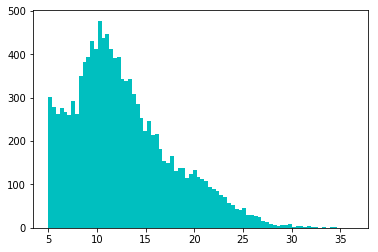

In [159]:
data_averaged = np.mean(data,axis=-1)  # average time points
# data_averaged = np.mean(detrended,axis=1)  # average time points

threshold = 5

plt.hist(data_averaged.flatten(), bins=80, color='c', range=(threshold, np.max(data)))
plt.show()

*Considering the rapid clearance of acetazolamide derivatives from the blood (with half-lives which are typically shorter than **15 min**) [30], [33], [42]*

source: https://www.sciencedirect.com/science/article/pii/S0168365916307350

In [148]:
# obsolete
# def custom_detrend_exp(x, baseline, endpoints):
#     t = np.arange(0,x.size)
#     t_bsl = t[0:baseline]
#     t_end = t[-endpoints:]
#     t_combine = np.append(t_bsl, t_end)
#     x_bsl = x[0:baseline]
#     x_end = x[-endpoints:]
#     x_combine = np.append(x_bsl, x_end)
    
#     x_log = np.log(x_combine)
#     t_log = np.log(t_combine)
#     fit = np.polyfit(t_log, x_log, 1)
#     trendline = np.polyval(fit, np.log(t))
#     x_detrended = x - np.exp(trendline) + np.mean(x)
#     return x_detrended, trendline


def exp_detrend(x, baseline, endpoints, t_res):
    """
    is called by prepare_data()
    """
    model = ExpressionModel('B*(1 - exp(-alpha * (x)))')

    params = model.make_params()
    params['alpha'].set(value=0.01,min=0.00001, max=1)
    params['B'].set(value=0.1, min=0.01, max=50)

    signal_a = x[:baseline]
    signal_b = x[-endpoints:]
    signal_combined = np.append(signal_a, signal_b)
    
    time = np.arange(0, x.size, 1)*t_res
    t_a = time[:baseline]
    t_b = time[-endpoints:]
    t_combined = np.append(t_a, t_b)
    
    result = model.fit(signal_combined, params, x=t_combined)

    fullfit = result.eval(x=np.arange(0,x.size)*dimensions.t_res)
    x_detrended = x - fullfit + np.mean(fullfit)
    
#     print(result.fit_report())
    
    return x_detrended, fullfit


def prepare_data(raw_input, baseline):
    if np.mean(raw_input) < threshold:   # <-- set this value above by looking at the histogram
        return np.zeros_like(raw_input), 0, 0, True
    else:
        skip = False
        
        # continue with concentration  - K * ln( S(t) / S(0) )  (we ignore K) 
        c = -np.log(raw_input / np.mean(raw_input[:baseline-5]))
    #     c_detrended, polyfit = h.custom_detrend(c, baseline-5)
        detrended, bslfit = exp_detrend(c, baseline-5, 50, dimensions.t_res)
        
    return detrended, c, bslfit, skip

In [ ]:
# run detrending for all voxels:
n_voxel = data_reshaped.shape[0]
detrended = np.zeros_like(data_reshaped)
skip_voxels = np.full(n_voxel, False)

for voxel in range(n_voxel):
    detrended[voxel,:], c, bslfit, skip_voxels[voxel] = prepare_data(data_reshaped[voxel,:], baseline)

# save intermediate result, open in AFNI for quality check    
scans={}
scans['Detrended'] = h.save_nifti(detrended, dimensions, folders, animal, 'detrended_conc_curve')

## slope, ttp, maximum, ...

In [ ]:
# using exponential fit to the data

def diamox_fit_parameters(c_detrended, baseline):
     # smoothing
#     c_smooth = savgol_filter(c_detrended, 19, 3) # window size, polynomial order

    # find first value after injection where signal returns to baseline value (to skip the dip artifact)
    bsl_value = np.mean(c_detrended[:baseline-5])
    
    start_point = np.argwhere(c_detrended[baseline+1:] >= bsl_value) + baseline + 1
    try:
        start_point = int(start_point[0]) #in some noise voxels it never returns to baseline, not sure what to set there
    except:
        start_point = baseline
        
    c_cut = c_detrended[start_point:] - bsl_value
    
    result, slope, maximum, TTP, signal, time = h.exp_fits(c_cut,0,c_cut.size,dimensions.t_res)
    
    return result, slope, maximum, TTP, signal, time
    

## single voxel tests

# voxel = 80*35*7 + 80*15 + 20
# x = data_reshaped[voxel,:]

# x=horizontal(left=0), y=vertical (top=0), z=slice (most anterior=0)
x = data[37,5,5,:]  # <-- corresponds to the x,y,z coordinates in AFNI viewer


detrended, c, bslfit, skip = prepare_data(x, baseline)

# fit_result, signal_combined, t_combined, fullfit = exp_detrend(x, baseline, 50, dimensions.t_res)



plt.figure()
plt.plot(x) 
plt.title('raw signal')


plt.figure()
plt.plot(c)
plt.title('concentration')

plt.figure()
plt.plot(bslfit)

plt.figure()
plt.plot(detrended)

# plt.figure()
# plt.plot(x - fullfit)



# for debugging plot single voxel results

voxel = 80*35*7 + 80*11 + 38

x = data_reshaped[voxel,:]

plt.figure()
plt.plot(x)  # raw signal of that voxel
plt.title('raw signal')

# to test single voxels, uncomment stuff below:

c_detrended, c, polyfit, skip = prepare_data(x, baseline)

print('skip:',skip)
plt.figure()
plt.plot(polyfit)

# slope, ttp = diamox_find_parameters(c_detrended, baseline)  # execute function below first
slope, ttp, fitoutput, signal, time = diamox_fit_parameters(c_detrended, baseline)  # execute function below first
print(f"slope: {slope}, ttp: {ttp}")


plt.figure()
plt.plot(time, signal)
plt.plot(time, fitoutput.best_fit)
plt.title('diamox fit')


plt.figure()
plt.plot(c)
plt.plot(c_detrended)

In [ ]:
# run it over all voxels

n_voxel = detrended.shape[0]
slope = np.zeros(n_voxel)
ttp = np.zeros(n_voxel)
maximum = np.zeros(n_voxel)

for voxel in range(n_voxel):
    if skip_voxels[voxel]: # those with signal values lower than "theshold" as defined above
        continue
    try:
        a, slope[voxel], maximum[voxel], ttp[voxel], e, f = diamox_fit_parameters(detrended[voxel,:], baseline)
    except:
        print(f"unknown error in voxel: {voxel}")

unknown error in voxel: 20236
unknown error in voxel: 20512
unknown error in voxel: 20519
unknown error in voxel: 20522
unknown error in voxel: 20541
unknown error in voxel: 20546
unknown error in voxel: 20556
unknown error in voxel: 20557


In [45]:
# save Nifti Files
scans={}
multiplication_factor = 1000 # <-- to prevent rounding errors, slope is normally very small
scans['diamox_slope'] = h.save_nifti(slope*multiplication_factor, dimensions, folders, animal, 'diamox_slope')
scans['diamox_ttp'] = h.save_nifti(ttp, dimensions, folders, animal, 'diamox_ttp')
scans['diamox_max'] = h.save_nifti(maximum, dimensions, folders, animal, 'diamox_max')


# save directories papermill for the main notebook:
pm.record("diamox_slope", scans['diamox_slope'])
pm.record("diamox_ttp", scans['diamox_ttp'])
pm.record("diamox_max", scans['diamox_max'])